## IPA for $R(p) := p/\mathbb{E}[A]$

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from collections import deque
import time
import nbimporter

In [6]:
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["text.latex.preamble"] = r"\usepackage{amsmath} \usepackage{amssymb}"

In [3]:
# Generates service times for n customers

def generate_service_times(x, n):
    # Exponentially distributed, Mean = 1/x
    service_times = np.random.exponential(1/x, n)
    # Gamma distributed, Mean = x[0]x[1], Variance = x[0]x[1]^2
    # service_times = np.random.gamma(x[0], x[1], n)
    return service_times

In [4]:
# Functions for F_p, F^{-1}_p, and d/dp F^{-1}_p

def F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    zeta = 0
    if x >= w:
        zeta = 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*w))/theta_2 + (x-w)))
    else:
        zeta = 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(w-x))-np.exp(-theta_2*w))/theta_2)
    return zeta
    
def inverse_F(zeta, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    A = 0
    if zeta >= F(w, w, price, model_vars):
        A = w - (1-np.exp(-theta_2*w))/theta_2 - np.log(1-zeta)*np.exp(theta_1*price)/lam
    else:
        A = (1/theta_2)*np.log(1-(theta_2/lam)*np.exp(theta_1*price+theta_2*w)*np.log(1-zeta))
    return A
    
    
def gradient_inverse_F(zeta, w, gradient_w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    gradient_A = 0
    if zeta >= F(w, w, price, model_vars):
        gradient_A = (1 - np.exp(-theta_2*w))*gradient_w - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-zeta)
    else:        
        gradient_A =  (theta_1 + theta_2*gradient_w)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*w)/np.log(1-zeta))
    return gradient_A

In [ ]:
# Simulates queue given seeds zeta, service times, price, and model variables

# Model will be as follows - First arrival is at time 0. If there are "n" interarrivals, then n+1 customers in total
# This means that simulation ends with one last customer joining, but no more interarrival times simulated

def queue_simulation(zeta, service_times, price, model_vars):
    n_customers = np.size(service_times)
    
    workload = 0
    
    w_plus = []
    w_minus = []
    interarrival_times = []
###################################################################################################################################################################################   
    for i in range(n_customers-1):
        w_minus.append(workload)
        workload += service_times[i]
        w_plus.append(workload)
        
        next_interarrival_time = inverse_F(zeta[i], workload, price, model_vars)
        interarrival_times.append(next_interarrival_time)
        
        workload = max(0, workload - next_interarrival_time)
    w_minus.append(workload)
    w_plus.append(workload+service_times[n_customers-1])
####################################################################################################################################################################################
    
    w_minus = np.array(w_minus)
    w_plus = np.array(w_plus)
    interarrival_times = np.array(interarrival_times)
    
    return [w_minus, w_plus, interarrival_times]

In [ ]:
def revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    n_interarrivals = np.size(interarrival_times)
    
    estimator_term_1 = np.mean(interarrival_times)
    estimator_term_2 = 0
    
    grad_waiting_time = 0
    gradient_waiting_times = []
    
    # This loop calculates gradients of waiting times of all customers
    for i in range(n_interarrivals):
        if w_minus[i] == 0:
            grad_waiting_time = 0
        else:
            grad_waiting_time -= gradient_inverse_F(zeta[i-1], w_plus[i-1], grad_waiting_time, price, model_vars)
        gradient_waiting_times.append(grad_waiting_time)
    
    # This loop calculates estimator_term_2
    for i in range(n_interarrivals):
        
        if gradient_inverse_F(zeta[i], w_plus[i], gradient_waiting_times[i], price, model_vars) < 0:
            print("Damn!")
        
        estimator_term_2 += (1/n_interarrivals)*gradient_inverse_F(zeta[i], w_plus[i], gradient_waiting_times[i], price, model_vars)
        
    revenue_grad_est = 1/estimator_term_1 - price*estimator_term_2/estimator_term_1**2
    
    # print("Range of gradient waiting time in simulation = ", [min(gradient_waiting_times), max(gradient_waiting_times)])
    
    return revenue_grad_est

In [ ]:
def implement_IPA(n_iters, initial_n_customers, initial_price, model_vars):
    
    price = initial_price
    price_iterates = [initial_price]
    
    for i in range(1, n_iters+1):
        
        # Generating data
        n_customers = (int)(initial_n_customers * math.sqrt(i))
        service_times = generate_service_times(1, n_customers)
        zeta = np.random.random(n_customers-1)
        
        # Queue simulation
        [w_minus, w_plus, interarrival_times] = queue_simulation(zeta, service_times, price, model_vars)
        
        # Gradient estimator
        revenue_grad_est = revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars)
        
        # Gradient ascent
        learning_rate = 10/np.power(i, 1)
        price = price + learning_rate*revenue_grad_est
    
        price_iterates.append(price)
        
        # print(i)
    
    return price_iterates

In [ ]:
# Simulation

n_iters = 100
N_0 = 100
initial_price = 1
model_vars = [10, 0.1, 0.2]

price_iterates = implement_IPA(n_iters, N_0, initial_price, model_vars)

In [ ]:
## Plots

optimal_price = 26.6

plt.plot(price_iterates, color = "blue")
plt.axhline(optimal_price, color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Price")
plt.title("IPA based gradient descent")
plt.savefig("IPA.pdf")

## Check

In [ ]:
n_customers = 10000
zeta = np.random.random(n_customers)
service_times = np.random.exponential(1, n_customers)
model_vars = [20, 0.1, 0.2]

prices = np.linspace(20.1, 30, 100)
revenue_gradients = []

for price in prices:
    [w_minus, w_plus, interarrival_times] = queue_simulation(zeta, service_times, price, model_vars)
    nabla_R = revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars)
    revenue_gradients.append(nabla_R)
    # print(price)

In [ ]:
optimal_price = 26.6

plt.plot(prices, revenue_gradients, color="blue", label = "Revenue gradient")
plt.xlabel("Price")
plt.ylabel("Revenue gradient estimator")
plt.axhline(0, color="red", linestyle="dashed")
plt.axvline(optimal_price, color="green", linestyle="dashed", label = "Optimal price")
plt.legend()
plt.savefig("True revenue gradient estimator.pdf")

## Plot for CDF of A for fixed price, and different initial workloads

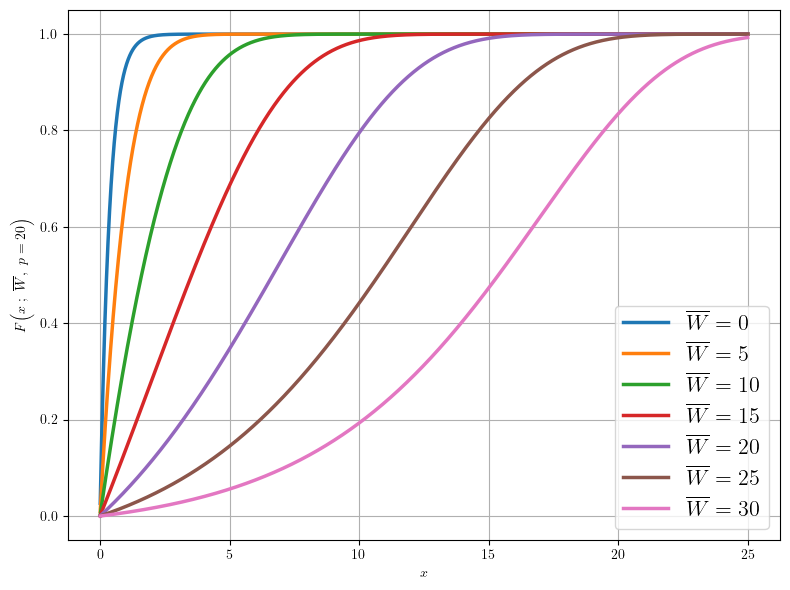

In [75]:
# Parameters
model_vars = [20, 0.1, 0.2]
price = 20
w_range = [0, 5, 10, 15, 20, 25, 30]
x_range = np.linspace(0.01, 25, 2501)

# Setup plot
plt.figure(figsize=(8, 6))

for w in w_range:
    F_range = [F(x, w, price, model_vars) for x in x_range]
    plt.plot(x_range, F_range, label=r"$\overline{W} = %s $"%w, linewidth = 2.5)

plt.xlabel(r"$x$")
plt.ylabel(r"$F\Big(x \ ; \ \overline{W}, \ p = 20\Big)$")
# plt.title("CDF of $A$ given $p = 20$ and different starting workloads $\overline{W}$")
# plt.legend(title=r"$\overline{W}$")
plt.legend(fontsize = 16)
plt.grid(True)
plt.tight_layout()

plt.savefig("CDF_fixed price_variable workload.png", dpi=300)

plt.show()

## Plot for CDF of A for fixed workload and different prices

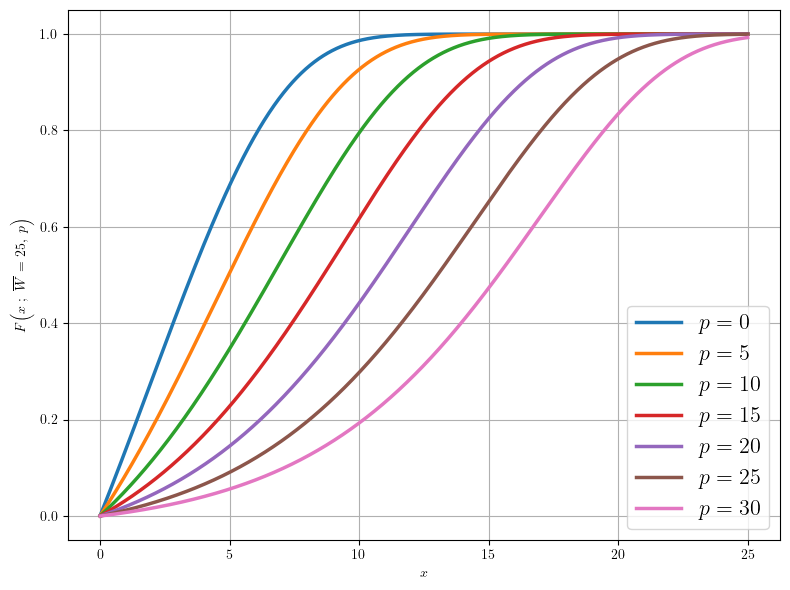

In [76]:
# Parameters
model_vars = [20, 0.1, 0.2]
w = 25
p_range = [0, 5, 10, 15, 20, 25, 30]
x_range = np.linspace(0.01, 25, 2500)

# Setup plot
plt.figure(figsize=(8, 6))

for p in p_range:
    F_range = [F(x, w, p, model_vars) for x in x_range]
    plt.plot(x_range, F_range, label=r"$p = %s $"%p, linewidth = 2.5)

plt.xlabel(r"$x$")
plt.ylabel(r"$F\Big(x \ ; \ \overline{W} = 25, \ p\Big)$")
# plt.title("CDF of $A$ given $p = 20$ and different starting workloads $\overline{W}$")
# plt.legend(title=r"$\overline{W}$")
plt.legend(fontsize = 16)
plt.grid(True)
plt.tight_layout()

plt.savefig("CDF_fixed workload_variable price.png", dpi=300)

plt.show()

## Plot for $F^{-1}(x \vert \overline{W}, p)$ for fixed price and different workloads

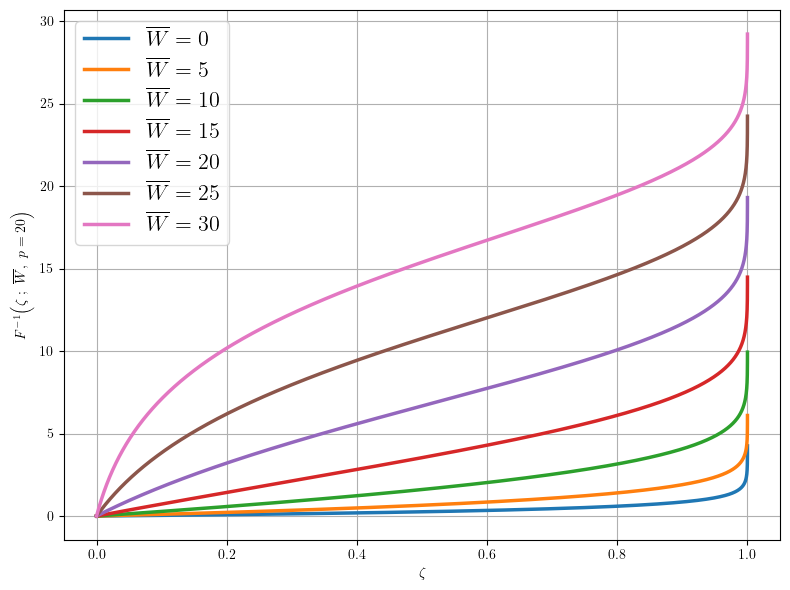

In [80]:
# Parameters
model_vars = [20, 0.1, 0.2]
price = 20
w_range = [0, 5, 10, 15, 20, 25, 30]
zeta_range = np.linspace(0, 0.99999, 100000)

# Setup plot
plt.figure(figsize=(8, 6))

for w in w_range:
    inv_F_range = [inverse_F(zeta, w, price, model_vars) for zeta in zeta_range]
    plt.plot(zeta_range, inv_F_range, label=r"$\overline{W} = %s $"%w, linewidth = 2.5)

plt.xlabel(r"$\zeta$")
plt.ylabel(r"$F^{-1}\Big(\zeta \ ; \ \overline{W}, \ p = 20\Big)$")
# plt.title("CDF of $A$ given $p = 20$ and different starting workloads $\overline{W}$")
# plt.legend(title=r"$\overline{W}$")
plt.legend(fontsize = 16)
plt.grid(True)
plt.tight_layout()

plt.savefig("Inverse_F_fixed price_variable workload.png", dpi=300)

plt.show()

## Plot for $F^{-1}(\zeta; \overline{W}, p)$ for fixed workload and different prices

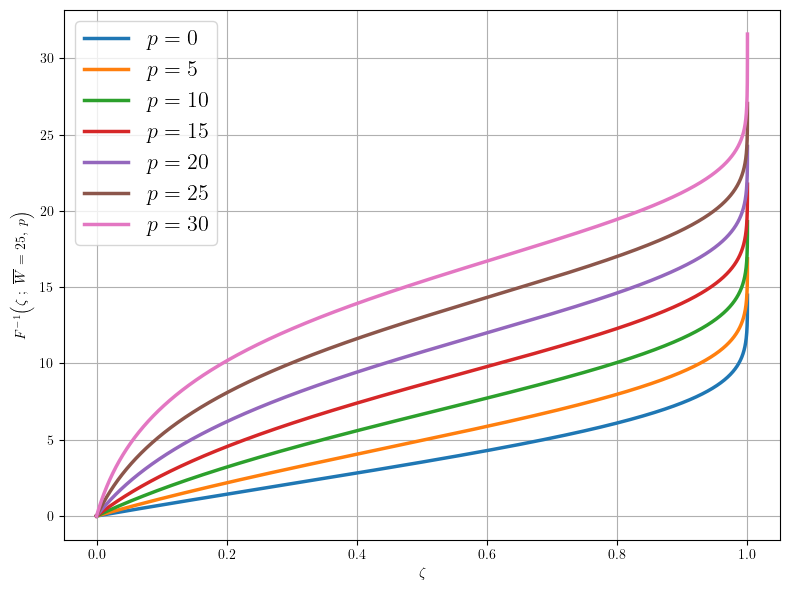

In [78]:
# Parameters
model_vars = [20, 0.1, 0.2]
w = 25
p_range = [0, 5, 10, 15, 20, 25, 30]
zeta_range = np.linspace(0, 0.99999, 100000)

# Setup plot
plt.figure(figsize=(8, 6))

for p in p_range:
    inv_F_range = [inverse_F(zeta, w, p, model_vars) for zeta in zeta_range]
    plt.plot(zeta_range, inv_F_range, label=r"$p = %s $"%p, linewidth = 2.5)

plt.xlabel(r"$\zeta$")
plt.ylabel(r"$F^{-1}\Big(\zeta \ ; \ \overline{W} = 25, \ p\Big)$")
# plt.title("CDF of $A$ given $p = 20$ and different starting workloads $\overline{W}$")
# plt.legend(title=r"$\overline{W}$")
plt.legend(fontsize = 16)
plt.grid(True)
plt.tight_layout()

plt.savefig("Inverse_F_fixed workload_variable price.png", dpi=300)

plt.show()

In [ ]:
# A plot for F^{-1}(zeta| W, price) versus zeta

model_vars = [20, 0.1, 0.2]
price = 26.6
w = 5
zeta_range = np.linspace(0, 0.999, 1000)
inv_F_range = []

for zeta in zeta_range:
    inv_F_range.append(inverse_F(zeta, w, price, model_vars))

plt.plot(zeta_range, inv_F_range, color="blue")
plt.xlabel("zeta")
plt.ylabel("x such that P(A <= x | W+ = %s) = zeta" %w)
plt.title("Interarrival time from seed zeta")

In [ ]:
# A plot for F^{-1}(zeta| W, price) versus price

model_vars = [20, 0.1, 0.2]
w = 5
zeta = 0.1

price_range = np.linspace(0.1, 20, 100)
inv_F_range = []

for price in price_range:
    inv_F_range.append(inverse_F(zeta, w, price, model_vars))
    
plt.plot(price_range, inv_F_range, color="blue")
plt.xlabel("price")


In [ ]:
# A plot for d/dp F^{-1}(zeta| W, price, dW/dp) versus price

model_vars = [20, 0.1, 0.2]
w = 10
gradient_w = -0.1
zeta = 0.1

price_range = np.linspace(0.1, 20, 100)
gradient_inv_F_range = []

for price in price_range:
    gradient_inv_F_range.append(gradient_inverse_F(zeta, w, gradient_w, price, model_vars))
    
plt.plot(price_range, gradient_inv_F_range, color="blue")
plt.xlabel("price")
